DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


iteration  0: residual = 1.056204e+00
iteration  1: residual = 1.286436e-01
iteration  2: residual = 6.064790e-03
iteration  3: residual = 1.730605e-05
0.00665996223538


<function matplotlib.pyplot.show>

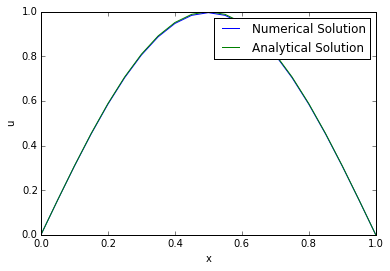

In [10]:
from dolfin import *
import numpy as np
get_ipython().magic('matplotlib inline')
get_ipython().magic('run /home/fenics/fenics-matplotlib.py')

# Define domain and mesh
mesh = UnitIntervalMesh(20)  

# Define function spaces
V = FunctionSpace(mesh, "CG", 1)   
Vhigh = FunctionSpace(mesh, "CG", 4)

# Define test and trial functions
dU = TrialFunction(V)
v = TestFunction(V)
U = Function(V)

# Define boundary and boundary conditions
def left(x, on_boundary):
    return abs(x[0]) < DOLFIN_EPS and on_boundary
    
def right(x, on_boundary):
    return abs( x[0]-1.0 ) < DOLFIN_EPS and on_boundary

bcs = [DirichletBC(V, '0.0', lambda x, on_boundary: on_boundary)]

# Exact solution
ue = Expression("sin(pi*x[0])")
uex = interpolate(ue, V)
uehigh = interpolate(ue, Vhigh)

# Initial solution
U_init = Expression("0")
    
# f in Bratu problem 
lamda = 2
f = Expression(("pow(pi,2)*sin(pi*x[0]) - lamda*exp(sin(pi*x[0]) )"), lamda = lamda, degree = 1)

# Weak form of Bratu problem
F = (dot(grad(v), grad(U)) - lamda*exp(U)*v) * dx - f*v*dx
J = derivative(F, U, dU)

####################### Newton's method manually #######################

# Initial solution
U.interpolate(U_init)

# Tolerance and BC
a_tol, r_tol = 1e-7, 1e-10
bcs_du = homogenize(bcs)

U_inc = Function(V)

# Prepare for Newton iterations
iters = 0
res = 1.0

# Perform Newton iterations
while res > 1e-4 and iters < 10:
    # Determine step direction
    A, b = assemble_system(J, -F, bcs_du)
    solve(A, U_inc.vector(), b)     
    res = b.norm('l2')
    
    print 'iteration {0:2d}: residual = {1:5e}'.format(iters, res)
    fnorm = b.norm('l2')

    # Prepare for next iteration
    U.vector()[:] += U_inc.vector()    
    iters += 1
    
# Compare numerical and exact solutions
err = sqrt(assemble((uehigh - U)*(uehigh-U)*dx))
ue_norm = sqrt(assemble(uehigh*uehigh*dx))
rel_err = err / ue_norm
print rel_err
    
########################################################################
    
# Plot solution
plt.figure
plt.plot(mesh.coordinates(), U.vector().array())
plt.plot(mesh.coordinates(), uex.vector().array())
plt.legend(["Numerical Solution", "Analytical Solution"])
plt.xlabel('x')
plt.ylabel('u')
plt.show